<a href="https://colab.research.google.com/github/Lee-Gunju/AI-paper-code-review-for-personal-project/blob/master/Classification_with_Gated_Residual_and_Variable_Selection_Networks(Structured_Data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Column names.
CSV_HEADER = [
    "age",
    "class_of_worker",
    "detailed_industry_recode",
    "detailed_occupation_recode",
    "education",
    "wage_per_hour",
    "enroll_in_edu_inst_last_wk",
    "marital_stat",
    "major_industry_code",
    "major_occupation_code",
    "race",
    "hispanic_origin",
    "sex",
    "member_of_a_labor_union",
    "reason_for_unemployment",
    "full_or_part_time_employment_stat",
    "capital_gains",
    "capital_losses",
    "dividends_from_stocks",
    "tax_filer_stat",
    "region_of_previous_residence",
    "state_of_previous_residence",
    "detailed_household_and_family_stat",
    "detailed_household_summary_in_household",
    "instance_weight",
    "migration_code-change_in_msa",
    "migration_code-change_in_reg",
    "migration_code-move_within_reg",
    "live_in_this_house_1_year_ago",
    "migration_prev_res_in_sunbelt",
    "num_persons_worked_for_employer",
    "family_members_under_18",
    "country_of_birth_father",
    "country_of_birth_mother",
    "country_of_birth_self",
    "citizenship",
    "own_business_or_self_employed",
    "fill_inc_questionnaire_for_veteran's_admin",
    "veterans_benefits",
    "weeks_worked_in_year",
    "year",
    "income_level",
]

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/census-income.data.gz"
data = pd.read_csv(data_url, header=None, names = CSV_HEADER)


In [ ]:
test_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/census-income.test.gz"
test_data = pd.read_csv(test_data_url, header=None, names = CSV_HEADER)

print(f"data shape: {data.shape}")
print(f"test_data shape: {test_data.shape}")

data shape: (199523, 42)
test_data shape: (99762, 42)


In [ ]:
data.income_level.value_counts()

 - 50000.    187141
 50000+.      12382
Name: income_level, dtype: int64

In [ ]:
data['income_level'] = data['income_level'].apply(lambda x: 0 if x == " - 50000." else 1)
test_data["income_level"] = test_data["income_level"].apply(lambda x : 0 if x == " - 50000." else 1)

In [ ]:
data[data['income_level'] != 1]

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_a_labor_union,reason_for_unemployment,full_or_part_time_employment_stat,capital_gains,capital_losses,dividends_from_stocks,tax_filer_stat,region_of_previous_residence,state_of_previous_residence,detailed_household_and_family_stat,detailed_household_summary_in_household,instance_weight,migration_code-change_in_msa,migration_code-change_in_reg,migration_code-move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,num_persons_worked_for_employer,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,income_level
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,0
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,0
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,87,Not in universe,0,0,7th and 8th grade,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,White,All other,Male,Not in universe,Not in universe,Not in labor force,0,0,0,Joint both 65+,Not in universe,Not in universe,Householder,Householder,955.27,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Canada,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,0
199519,65,Self-employed-incorporated,37,2,11th grade,0,Not in universe,Married-civilian spouse 

In [ ]:
random_selection = np.random.rand(len(data.index)) <= 0.85

In [ ]:
train_data = data[random_selection] 
valid_data = data[~random_selection]

In [ ]:
train_data_file = "train_data.csv"
valid_data_file = "valid_data.csv"
test_data_file = "test_data.csv"


train_data.to_csv(train_data_file, index = False, header= False)
valid_data.to_csv(valid_data_file, index = False, header= False)
test_data.to_csv(test_data_file, index = False, header=False)

In [ ]:
# Target feature name.
TARGET_FEATURE_NAME = "income_level"
# Weight column name.
WEIGHT_COLUMN_NAME = "instance_weight"
# Numeric feature names.
NUMERIC_FEATURE_NAMES = [
    "age",
    "wage_per_hour",
    "capital_gains",
    "capital_losses",
    "dividends_from_stocks",
    "num_persons_worked_for_employer",
    "weeks_worked_in_year",
]

# Categorical features and their vocabulary lists.
# Note that we add 'v=' as a prefix to all categorical feature values to make
# sure that they are treated as strings.



In [ ]:
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    feature_name : sorted([str(value) for value in list(data[feature_name].unique())])
    for feature_name in CSV_HEADER
    if feature_name not in list(NUMERIC_FEATURE_NAMES + [WEIGHT_COLUMN_NAME, TARGET_FEATURE_NAME])
}

In [ ]:
CATEGORICAL_FEATURES_WITH_VOCABULARY

{'citizenship': [' Foreign born- Not a citizen of U S ',
  ' Foreign born- U S citizen by naturalization',
  ' Native- Born abroad of American Parent(s)',
  ' Native- Born in Puerto Rico or U S Outlying',
  ' Native- Born in the United States'],
 'class_of_worker': [' Federal government',
  ' Local government',
  ' Never worked',
  ' Not in universe',
  ' Private',
  ' Self-employed-incorporated',
  ' Self-employed-not incorporated',
  ' State government',
  ' Without pay'],
 'country_of_birth_father': [' ?',
  ' Cambodia',
  ' Canada',
  ' China',
  ' Columbia',
  ' Cuba',
  ' Dominican-Republic',
  ' Ecuador',
  ' El-Salvador',
  ' England',
  ' France',
  ' Germany',
  ' Greece',
  ' Guatemala',
  ' Haiti',
  ' Holand-Netherlands',
  ' Honduras',
  ' Hong Kong',
  ' Hungary',
  ' India',
  ' Iran',
  ' Ireland',
  ' Italy',
  ' Jamaica',
  ' Japan',
  ' Laos',
  ' Mexico',
  ' Nicaragua',
  ' Outlying-U S (Guam USVI etc)',
  ' Panama',
  ' Peru',
  ' Philippines',
  ' Poland',
  ' P

In [ ]:
# All features names.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

# Feature default values.
COLUMN_DEFAULTS = [
                   [0.0]
                   if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME, WEIGHT_COLUMN_NAME]
                   else ["NA"]
                   for feature_name in CSV_HEADER
]

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

def process(features, target):
  for feature_name in features:
    if feature_name in CATEGORICAL_FEATURES_WITH_VOCABULARY:
      # Cast categorical feature values to string.
      features[feature_name] = tf.cast(features[feature_name], tf.dtypes.string)
  
  # Get the instance weight.
  weight = features.pop(WEIGHT_COLUMN_NAME)
  return features, target, weight

def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size=128):

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        shuffle=shuffle,
    ).map(process)

    return dataset

In [ ]:
def create_model_inputs():
  inputs = {}
  for feature_name in FEATURE_NAMES:
    if feature_name in NUMERIC_FEATURE_NAMES:
      inputs[feature_name] = layers.Input(name = feature_name, shape = (), dtype=tf.float32)

    else:
      inputs[feature_name] = layers.Input(name = feature_name, shape = (), dtype = tf.string)
  
  return inputs

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

def encode_inputs(inputs, encoding_size):
  encoded_features = []
  for feature_name in inputs:
    if feature_name in CATEGORICAL_FEATURES_WITH_VOCABULARY:
      vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
      # Create a lookup to convert a string values to an integer indices.
      # Since we are not using a mask token nor expecting any out of vocabulary
      # (oov) token, we set mask_token to None and  num_oov_indices to 0.
      index = StringLookup(vocabulary=vocabulary, mask_token = None, num_oov_indices = 0)
      # Convert the string input values into integer indices.
      value_index = index(inputs[feature_name])
      # Create an embedding layer with the specified dimensions
      embedding_ecoder = layers.Embedding(input_dim=len(vocabulary), output_dim= encoding_size)
      # Convert the index values to embedding representations.
      encoded_feature = embedding_ecoder(value_index)
    else:
      # Project the numeric feature to encoding_size using linear transformation.
      encoded_feature = tf.expand_dims(inputs[feature_name], -1)
      encoded_feature = layers.Dense(units = encoding_size)(encoded_feature)
    encoded_features.append(encoded_feature)
  
  return encoded_features







In [ ]:
a

{'age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'age')>,
 'capital_gains': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'capital_gains')>,
 'capital_losses': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'capital_losses')>,
 'citizenship': <KerasTensor: shape=(None,) dtype=string (created by layer 'citizenship')>,
 'class_of_worker': <KerasTensor: shape=(None,) dtype=string (created by layer 'class_of_worker')>,
 'country_of_birth_father': <KerasTensor: shape=(None,) dtype=string (created by layer 'country_of_birth_father')>,
 'country_of_birth_mother': <KerasTensor: shape=(None,) dtype=string (created by layer 'country_of_birth_mother')>,
 'country_of_birth_self': <KerasTensor: shape=(None,) dtype=string (created by layer 'country_of_birth_self')>,
 'detailed_household_and_family_stat': <KerasTensor: shape=(None,) dtype=string (created by layer 'detailed_household_and_family_stat')>,
 'detailed_household_summary_in_household': <KerasTen

In [ ]:
a['age']

<KerasTensor: shape=(None,) dtype=float32 (created by layer 'age')>

In [ ]:
tf.expand_dims(a['age'], -1)

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_1')>

In [ ]:
class GatedLinearUnit(layers.Layer):
  def __init__(self, units):
    super(GatedLinearUnit, self).__init__()
    self.linear = layers.Dense(units)
    self.sigmoid = layers.Dense(units, activation='sigmoid')

  def call(self, inputs):
    return self.linear(inputs) * self.sigmoid(inputs)

In [ ]:
class GatedResidualNetwork(layers.Layer):
  def __init__(self, units, dropout_rate):
    super(GatedResidualNetwork, self).__init__()
    self.units = units
    self.elu_dense = layers.Dense(units, activation='elu')
    self.linear_dense = layers.Dense(units)
    self.dropout = layers.Dropout(dropout_rate)
    self.gated_linear_unit = GatedLinearUnit(units)
    self.layer_norm = layers.LayerNormalization()
    self.project = layers.Dense(units)

  def call(self, inputs):
    x = self.elu_dense(inputs)
    x = self.linear_dense(x)
    x = self.dropout(x)
    if inputs.shape[-1] != self.units:
      inputs = self.project(inputs)
    x = inputs + self.gated_linear_unit(x)
    x = self.layer_norm(x)
    return x


In [ ]:
class VariableSelection(layers.Layer):
  def __init__(self, num_features, units, dropout_rate):
    super(VariableSelection, self).__init__()
    self.grns = list()
    # Create a GRN for each feature independently
    for idx in range(num_features):
      grn = GatedResidualNetwork(units, dropout_rate)
      self.grns.append(grn)
    # Create a GRN for the concatenation of all the features
    self.grn_concat = GatedResidualNetwork(units, dropout_rate)
    self.softmax = layers.Dense(units = num_features, activation='softmax')

  def call(self, inputs):
    v = layers.concatenate(inputs)
    v = self.grn_concat(v)
    v = tf.expand_dims(self.softmax(v), axis = -1)
    
    x = []
    for idx, input in enumerate(inputs):
      x.append(self.grns[idx](input))
    x = tf.stack(x, axis = 1)

    outputs= tf.squeeze(tf.matmul(v, x, transpose_a=True), axis = 1)
    return outputs

In [ ]:
def create_model(encoding_size):
  inputs = create_model_inputs()
  feature_list = encode_inputs(inputs, encoding_size)
  num_features = len(feature_list)
  features = VariableSelection(num_features, encoding_size, dropout_rate)(feature_list)

  outputs = layers.Dense(1, activation='sigmoid')(features)
  model = keras.Model(inputs = inputs, outputs = outputs)
  return model

In [ ]:
learning_rate = 0.001
dropout_rate = 0.15
batch_size = 265
num_epochs = 20
encoding_size = 16

model = create_model(encoding_size)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
)


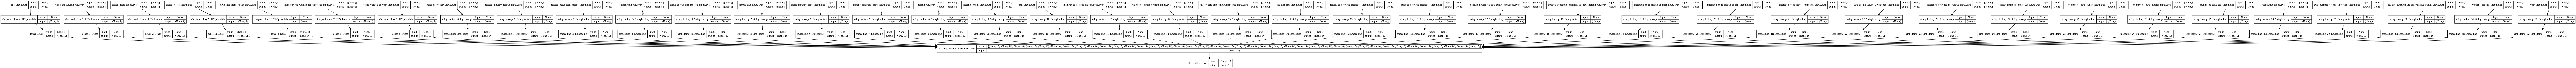

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
age (InputLayer)                [(None,)]            0                                            
__________________________________________________________________________________________________
wage_per_hour (InputLayer)      [(None,)]            0                                            
__________________________________________________________________________________________________
capital_gains (InputLayer)      [(None,)]            0                                            
__________________________________________________________________________________________________
capital_losses (InputLayer)     [(None,)]            0                                            
______________________________________________________________________________________________

In [ ]:
# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

In [ ]:
print("Start training the model...")
train_dataset = get_dataset_from_csv(
    train_data_file, shuffle=True, batch_size=batch_size
)
valid_dataset = get_dataset_from_csv(valid_data_file, batch_size=batch_size)
model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)
print("Model training finished.")

print("Evaluating model performance...")
test_dataset = get_dataset_from_csv(test_data_file, batch_size=batch_size)
_, accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Start training the model...
Epoch 1/20
641/641 [==============================] - 79s 51ms/step - loss: 308.7421 - accuracy: 0.9404 - val_loss: 237.6896 - val_accuracy: 0.9472
Epoch 2/20
641/641 [==============================] - 30s 47ms/step - loss: 229.5257 - accuracy: 0.9501 - val_loss: 234.7022 - val_accuracy: 0.9471
Epoch 3/20
641/641 [==============================] - 31s 47ms/step - loss: 224.0862 - accuracy: 0.9510 - val_loss: 228.6603 - val_accuracy: 0.9485
Epoch 4/20
641/641 [==============================] - 30s 46ms/step - loss: 221.1203 - accuracy: 0.9512 - val_loss: 225.8021 - val_accuracy: 0.9499
Epoch 5/20
641/641 [==============================] - 32s 49ms/step - loss: 219.9374 - accuracy: 0.9510 - val_loss: 226.2758 - val_accuracy: 0.9498
Epoch 6/20
641/641 [==============================] - 31s 48ms/step - loss: 218.4861 - accuracy: 0.9516 - val_loss: 225.5280 - val_accuracy: 0.9499
Epoch 7/20
641/641 [==============================] - 31s 47ms/step - loss: 215.8379